In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_pinball_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


X = pd.read_csv('X.csv', index_col = 0)
y = np.array(pd.read_csv('y.csv', index_col = 0)).ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the quantiles for the prediction intervals
quantiles = [0.1, 0.5, 0.9]

# Train XGBRegressor models for each quantile
xgb_models = {}
for quantile in quantiles:
    model = XGBRegressor(objective="reg:quantileerror", quantile_alpha=quantile, n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    xgb_models[quantile] = model

# Train Linear Quantile Regressor models for each quantile
linear_models = {}
for quantile in quantiles:
    model = QuantileRegressor(quantile=quantile, alpha=0.1, solver="highs")
    model.fit(X_train, y_train)
    linear_models[quantile] = model

# Make predictions on the test set for XGBRegressor
xgb_predictions = {}
for quantile in quantiles:
    xgb_predictions[quantile] = xgb_models[quantile].predict(X_test)

# Make predictions on the test set for Linear Quantile Regression
linear_predictions = {}
for quantile in quantiles:
    linear_predictions[quantile] = linear_models[quantile].predict(X_test)

# Calculate and compare pinball loss for each quantile and model
for quantile in quantiles:
    xgb_loss = mean_pinball_loss(y_test, xgb_predictions[quantile], alpha=quantile)
    linear_loss = mean_pinball_loss(y_test, linear_predictions[quantile], alpha=quantile)
    print(f"Quantile {quantile}:")
    print(f"  XGBRegressor Pinball Loss: {xgb_loss:.10f}")
    print(f"  LinearQuantileRegression Pinball Loss: {linear_loss:.10f}")




Quantile 0.1:
  XGBRegressor Pinball Loss: 0.0000572330
  LinearQuantileRegression Pinball Loss: 0.0000691916
Quantile 0.5:
  XGBRegressor Pinball Loss: 0.0001087833
  LinearQuantileRegression Pinball Loss: 0.0001109689
Quantile 0.9:
  XGBRegressor Pinball Loss: 0.0000571647
  LinearQuantileRegression Pinball Loss: 0.0000665104


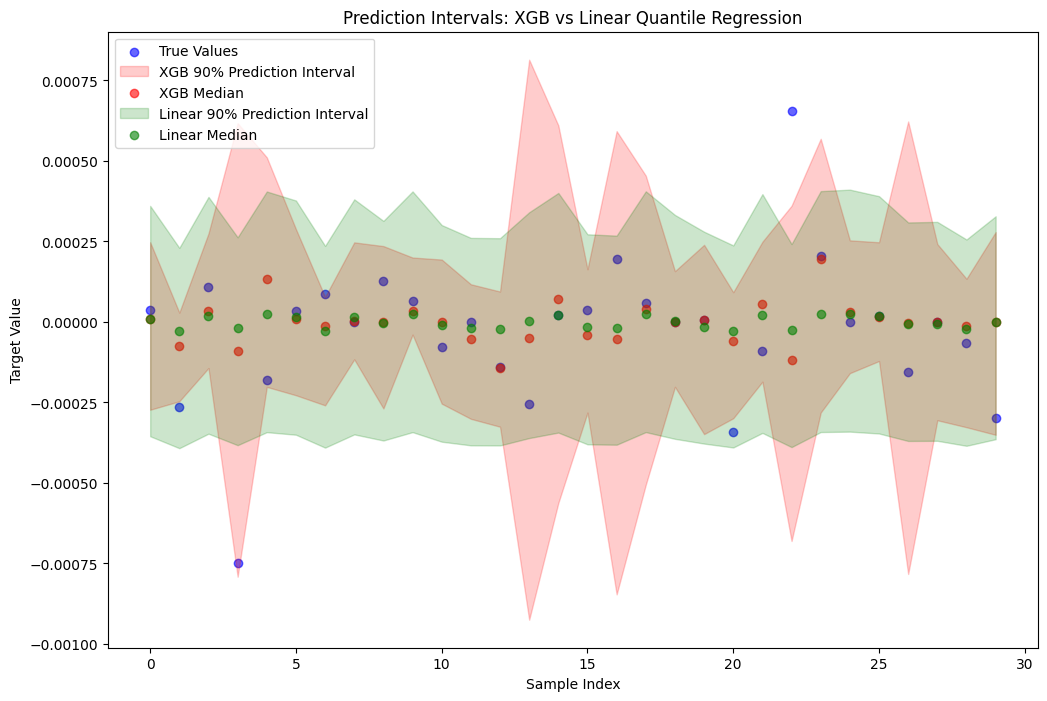

In [2]:
vis = 30

# Visualize the predicted intervals for both models and true values
plt.figure(figsize=(12, 8))

# Plot true values
plt.scatter(range(len(y_test[-vis:])), y_test[-vis:], color="blue", label="True Values", alpha=0.6)



# Plot XGBRegressor intervals
plt.fill_between(range(len(y_test[-vis:])), xgb_predictions[0.1][-vis:], xgb_predictions[0.9][-vis:], color="red", alpha=0.2, label="XGB 90% Prediction Interval")
plt.scatter(range(len(xgb_predictions[0.5][-vis:])), xgb_predictions[0.5][-vis:], color="red", label="XGB Median", alpha=0.6)

# Plot Linear Quantile Regression intervals
plt.fill_between(range(len(y_test[-vis:])), linear_predictions[0.1][-vis:], linear_predictions[0.9][-vis:], color="green", alpha=0.2, label="Linear 90% Prediction Interval")
plt.scatter(range(len(linear_predictions[0.5][-vis:])), linear_predictions[0.5][-vis:], color="green", label="Linear Median", alpha=0.6)

# Add labels and legend
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("Prediction Intervals: XGB vs Linear Quantile Regression")
plt.legend()
plt.show()

In [3]:
# Calculate naive model's pinball loss for each quantile
naive_predictions = {quantile: np.percentile(y_train, quantile * 100) for quantile in quantiles}

naive_losses = {}
for quantile in quantiles:
    naive_losses[quantile] = mean_pinball_loss(y_test, [naive_predictions[quantile]] * len(y_test), alpha=quantile)

# Add pseudo R^2 calculations
for quantile in quantiles:
    # XGBoost
    xgb_loss = mean_pinball_loss(y_test, xgb_predictions[quantile], alpha=quantile)
    xgb_pseudo_r2 = 1 - (xgb_loss / naive_losses[quantile])
    
    # Linear Quantile Regression
    linear_loss = mean_pinball_loss(y_test, linear_predictions[quantile], alpha=quantile)
    linear_pseudo_r2 = 1 - (linear_loss / naive_losses[quantile])
    
    # Print results
    print(f"Quantile {quantile}:")
    print(f"  XGBRegressor Pinball Loss: {xgb_loss:.10f}, Pseudo R^2: {xgb_pseudo_r2:.4f}")
    print(f"  LinearQuantileRegression Pinball Loss: {linear_loss:.10f}, Pseudo R^2: {linear_pseudo_r2:.4f}")


Quantile 0.1:
  XGBRegressor Pinball Loss: 0.0000572330, Pseudo R^2: 0.1768
  LinearQuantileRegression Pinball Loss: 0.0000691916, Pseudo R^2: 0.0048
Quantile 0.5:
  XGBRegressor Pinball Loss: 0.0001087833, Pseudo R^2: 0.0246
  LinearQuantileRegression Pinball Loss: 0.0001109689, Pseudo R^2: 0.0050
Quantile 0.9:
  XGBRegressor Pinball Loss: 0.0000571647, Pseudo R^2: 0.1618
  LinearQuantileRegression Pinball Loss: 0.0000665104, Pseudo R^2: 0.0247


In [4]:
selected_xg = []
for i in range(len(xgb_predictions[0.1])):
    if xgb_predictions[0.1][i]>0:
        selected_xg.append(y_test[i])



selected_lin = []
for i in range(len(linear_predictions[0.1])):
    if linear_predictions[0.1][i]>0:
        selected_lin.append(y_test[i])



cumulative_returns = 1
for r in selected_xg:
    cumulative_returns *= (1 + r)
print('xgb', cumulative_returns)



cumulative_returns = 1
for r in selected_lin:
    cumulative_returns *= (1 + r)
print('lin', cumulative_returns)

xgb 1.0043767950088967
lin 1
